# **CSV & Libraries import**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

file_path = "../data/unique_users_after_labeling2.csv"
df = pd.read_csv(file_path)

# Initial data
df.head()


,userid,totaltweets,avg_retweetcount,followers,following,acctdesc,label
0,22240612,347147,1.755378,925487,46,The Arab world’s leading source of global news...,0
1,6135622,172270,39.639711,1367996,169,Desde Alemania para América Latina. Todo lo qu...,0
2,848416437030985728,3634,1.000000,47826,261,"Changsha, the capital of central China’s Hunan...",0
3,984429894829592576,16116,0.398857,328,72,"🌐✈Blog de aviación, viajes y economía para via...",0
4,807095565028917248,8325,18.340000,26020,15984,Nature heals. Birding in China: best photos+vi...,0


# **Data Checks**

In [14]:
# Check relevant columns
df.columns

# total predicted bots
df["label"].value_counts()


label
0    2324724
1      64955
Name: count, dtype: int64

# **User Split**
**Conclusion:** The model predicts that the vast majority of users in the dataset are human, with only a small fraction labeled as bots. This skewed distribution may reflect the real-world prevalence of human accounts on Twitter, but it could also indicate conservative bot detection behavior by the model.

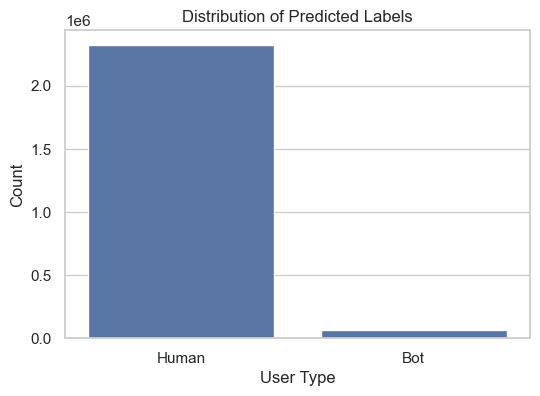

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.xticks([0, 1], ["Human", "Bot"])
plt.title("Distribution of Predicted Labels")
plt.xlabel("User Type")
plt.ylabel("Count")
plt.show()


# **Average Features Comparison for Humans and Bots**
**Conclusion:** On average, human accounts exhibit higher engagement metrics across all features, including tweet volume, follower count, and average retweet count. This suggests that bots in the dataset are generally less active and less influential in terms of visibility and reach.

In [16]:
df.groupby("label")[["totaltweets", "avg_retweetcount", "followers", "following"]].mean()


,totaltweets,avg_retweetcount,followers,following
label,,,,
0,18722.549034,406.129959,4613.884333,1045.554498
1,12265.809714,300.742788,1568.636025,918.062212


# **totaltweets split**
**Conclusion:** The distribution shows that both humans and bots are most active in the lower to mid tweet ranges, but humans are significantly more represented across all tweet volumes. Bots tend to cluster in lower activity levels, suggesting more limited engagement behavior overall.

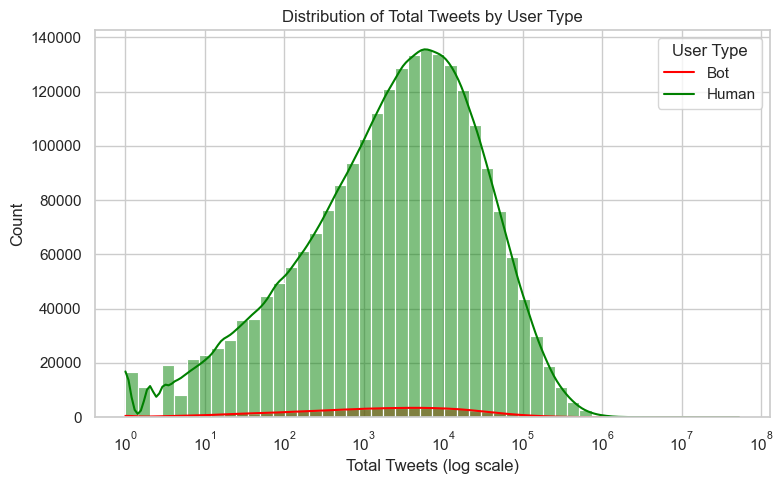

In [24]:
# Clean
df_clean = df[(df["totaltweets"].notna()) & (df["totaltweets"] > 0)]

plt.figure(figsize=(8,5))
sns.histplot(
    data=df_clean,
    x="totaltweets",
    hue="label",
    bins=50,
    log_scale=True,
    kde=True,
    palette={0: "green", 1: "red"}
)
plt.title("Distribution of Total Tweets by User Type")
plt.xlabel("Total Tweets (log scale)")
plt.legend(title="User Type", labels=["Bot", "Human"])
plt.tight_layout()
plt.show()


# **avg_retweetcount Boxplot**
**Conclusion:** While both humans and bots exhibit a wide range of average retweet counts, human accounts tend to have a slightly higher median and more extreme outliers. This suggests that although bots can achieve visibility, humans generally receive more consistent and occasionally viral engagement.

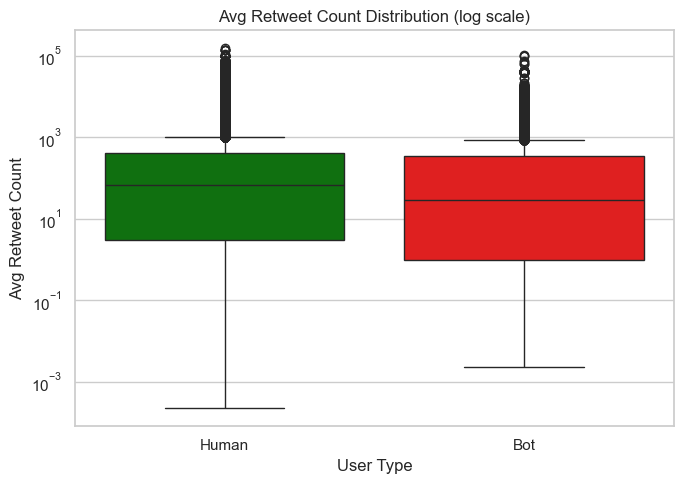

In [18]:
# Cast
df["label"] = df["label"].astype(int)

# Filter NaNs
df_box = df[df["avg_retweetcount"].notna() & (df["avg_retweetcount"] > 0)]

# Plot
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df_box,
    x="label",
    y="avg_retweetcount",
    hue="label",
    palette={0: "green", 1: "red"},
    legend=False
)
plt.xticks([0,1], ["Human", "Bot"])
plt.yscale("log")
plt.title("Avg Retweet Count Distribution (log scale)")
plt.xlabel("User Type")
plt.ylabel("Avg Retweet Count")
plt.tight_layout()
plt.show()


# **Followers vs. Following Scatter Graph**
**Conclusion:** Most users, regardless of type, cluster in the lower ranges of both followers and following, with a few human accounts reaching extremely high follower counts. Bots appear more concentrated in regions with low follower-to-following ratios, reflecting less organic influence and potentially artificial follow patterns.

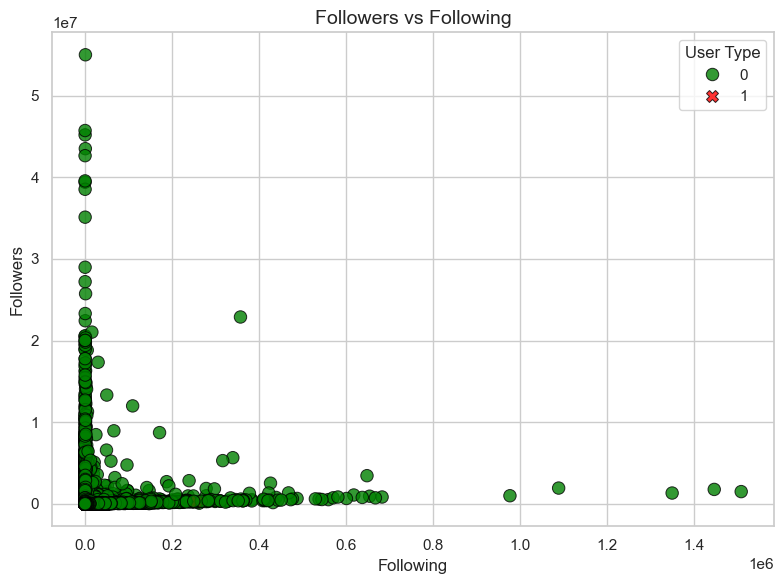

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="following",
    y="followers",
    hue="label",
    palette={0: "green", 1: "red"},
    style="label",
    markers={0: "o", 1: "X"},
    s=80,
    edgecolor="black",
    alpha=0.8
)

plt.title("Followers vs Following", fontsize=14)
plt.xlabel("Following", fontsize=12)
plt.ylabel("Followers", fontsize=12)
plt.legend(title="User Type", loc="upper right")
plt.tight_layout()
plt.show()


# **Followers / Following Ratio**
**Conclusion:** Both humans and bots tend to have low follower-to-following ratios, but bots are more densely concentrated in the lowest ratio ranges. This suggests that bots typically follow many accounts while receiving relatively few followers in return — a common indicator of automated or inauthentic behavior.

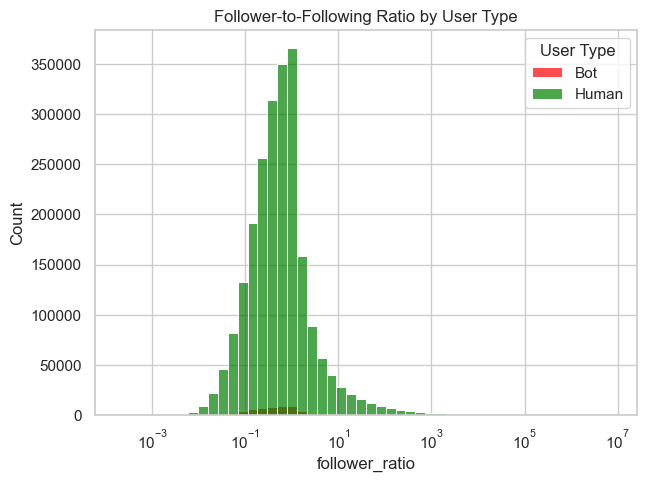

In [25]:
df["follower_ratio"] = df["followers"] / (df["following"] + 1)

plt.figure(figsize=(7,5))
sns.histplot(data=df, x="follower_ratio", hue="label", bins=50, log_scale=True, palette={0: "green", 1: "red"}, alpha=0.7)
plt.title("Follower-to-Following Ratio by User Type")
plt.legend(title="User Type", labels=["Bot", "Human"])
plt.show()


# **Features Heatmap**
**Conclusion:** The heatmap reveals generally weak correlations among the features, with the strongest relationship observed between followers and follower_ratio. This indicates that most features contribute independent signals, which can be valuable for distinguishing between user types in classification tasks.

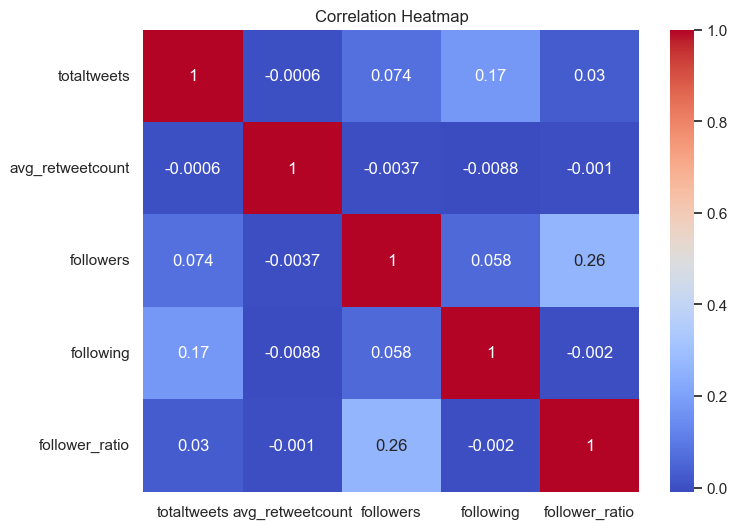

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["totaltweets", "avg_retweetcount", "followers", "following", "follower_ratio"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# **20 Most Common Words Per Label**
**Conclusion:** Human account descriptions tend to emphasize personal interests, emotions, and identity (e.g., "love", "life", "music", "fan"), reflecting expressive and social behavior. In contrast, bot descriptions frequently contain business and tech-related terms like "crypto", "nft", and "trader", suggesting promotional or commercial intent.

In [22]:
from collections import Counter
import pandas as pd
import re

# Clean text
def get_top_words(text, stopwords=set(), n=20):
    # Clean numbers and symbols
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
    return Counter(filtered_words).most_common(n)

# Stopwords
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# Texts
text_humans = " ".join(df[df["label"] == 0]["acctdesc"].dropna().astype(str))
text_bots = " ".join(df[df["label"] == 1]["acctdesc"].dropna().astype(str))

# Count
top_human_words = get_top_words(text_humans, stopwords)
top_bot_words = get_top_words(text_bots, stopwords)

# Plot
df_top_human = pd.DataFrame(top_human_words, columns=["Word", "Count"]).reset_index(drop=True)
df_top_bot = pd.DataFrame(top_bot_words, columns=["Word", "Count"]).reset_index(drop=True)

print("🔹 Top 20 Human Description Words")
display(df_top_human)

print("🔹 Top 20 Bot Description Words")
display(df_top_bot)


🔹 Top 20 Human Description Words


,Word,Count
0,https,139495
1,love,60323
2,life,44901
3,fan,44883
4,world,38724
5,que,38015
6,news,33825
7,lover,30238
8,follow,29417
9,music,29281


🔹 Top 20 Bot Description Words


,Word,Count
0,https,3943
1,crypto,2629
2,world,1658
3,news,1630
4,trader,1391
5,nft,1300
6,life,1193
7,business,1192
8,digital,1146
9,media,1122


# **Summary**

## **General Observations**
- The majority of user accounts were classified as human, with bots comprising only a small minority of the dataset.
- This skewed distribution reflects either a realistic representation of Twitter's user base or a conservative classification tendency by the model.

## **Behavioral Feature Analysis**
#### **Tweet Volume (totaltweets)**
- Both humans and bots are concentrated in low-to-mid tweet ranges.
- However, humans appear across a wider distribution, indicating more consistent long-term activity.

#### **Average Retweet Count (avg_retweetcount)**
- Humans exhibit higher median retweet counts and more extreme outliers.
- Bots tend to receive fewer retweets on average, suggesting lower organic engagement and influence.

#### **Followers vs Following**
- Most users cluster around low follower and following counts.
- Bots tend to have a lower follower-to-following ratio, likely reflecting automated behavior aimed at inflating reach.

#### **Follower-to-Following Ratio**
- Bots are concentrated in extremely low ratios (e.g., < 0.1), while humans show more balanced patterns.
- This metric proves to be a strong behavioral signal for identifying bot-like behavior.

## **Feature Correlation**
- All numeric features show weak correlations with one another (max ~0.32).
- This indicates that each feature contributes independently to the classification task, which is desirable in model design.

## **Textual Analysis: Account Descriptions**
### **Human Descriptions**
- Dominated by emotionally expressive and interest-related words such as:
"love", "life", "music", "fan", "god", "proud"
- Common use of "https" suggests profile links or shared content.

### **Bot Descriptions**
- Tend to focus on commercial or technical keywords such as:
"crypto", "nft", "trader", "bitcoin", "engineer", "marketing"
- Also include "https" heavily, likely reflecting external promotions or spam.

## **Conclusions**
- Bots in this dataset display distinct behavioral and textual patterns compared to human users.
- Key distinguishing features include: lower retweet engagement, imbalanced follower dynamics, and commercially oriented profile descriptions.
- The hybrid model combining textual embeddings and metadata effectively captures these differences and enables scalable bot detection during high-volume events such as geopolitical conflicts.

In [23]:
summary = df.groupby("label")[["totaltweets", "avg_retweetcount", "followers", "following"]].agg(['mean', 'median', 'std'])
summary


totaltweets                       avg_retweetcount            \
               mean  median           std             mean    median   
label                                                                  
0      18722.549034  3017.0  66831.055857       406.129959  0.666667   
1      12265.809714  1630.0  39909.796322       300.742788  0.000000   

                      followers                          following         \
               std         mean median            std         mean median   
label                                                                       
0      2194.215079  4613.884333  168.0  142167.748967  1045.554498  320.0   
1      1863.480644  1568.636025  126.0   17742.237713   918.062212  246.0   

                    
               std  
label               
0      4366.443844  
1      3120.275029

# **Key Research Conclusions**

**Research Question:** How do bots influence social discourse during the Russia–Ukraine war?

1. **Bots are present but not dominant**
Although bots represent a small fraction of the total Twitter user base, their presence is significant in scale given the size of the dataset, indicating a non-negligible level of automated participation in the wartime discourse.

2. **Bots exhibit distinct behavioral patterns**
Compared to humans, bots tend to have fewer followers, follow more accounts, and maintain lower follower-to-following ratios. They also receive fewer retweets on average, suggesting limited organic engagement.

3. **Textual analysis reveals strategic positioning**
Bot account descriptions often include terms related to cryptocurrency, trading, marketing, and digital media — indicating a coordinated attempt to blend commercial or ideological content into the broader conflict narrative. In contrast, human descriptions are more expressive and personal.

4. **Bots likely aim to amplify rather than engage**
The data suggests that bots are less about starting conversations and more about disseminating targeted messages at scale — a behavior consistent with propaganda and disinformation strategies during conflicts.

5. **Potential influence is qualitative, not just quantitative**
Even if bots don’t dominate engagement metrics, their potential impact lies in the content they inject and the narratives they attempt to shape, especially in emotionally and politically charged contexts like the Russia–Ukraine war.